In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/gdrive')
cv2.ocl.setUseOpenCL(False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [72]:
feature_extractor = 'orb' # выбираем из 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

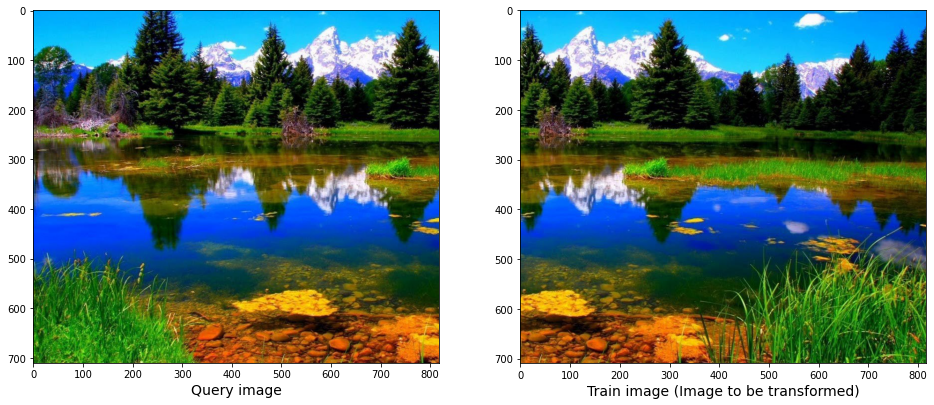

In [73]:
# считывайте изображения и преобразуйте их в оттенки серого
trainImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto2A.jpg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto2B.jpg')
# Opencv определяет цветовой канал в порядке BGR. 
# Преобразуем его в RGB, чтобы он был совместим с matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [74]:
def detectAndDescribe(image, method=None):
    """
    Вычислите ключевые точки и дескрипторы объектов, используя определенный метод
    """
    
    assert method is not None, "Вам нужно определить метод обнаружения объектов. Выбери из: 'sift', 'surf'"
    
    # обнаружение и извлечение объектов из изображения
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # получение ключевых точек и дескрипторов
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [75]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

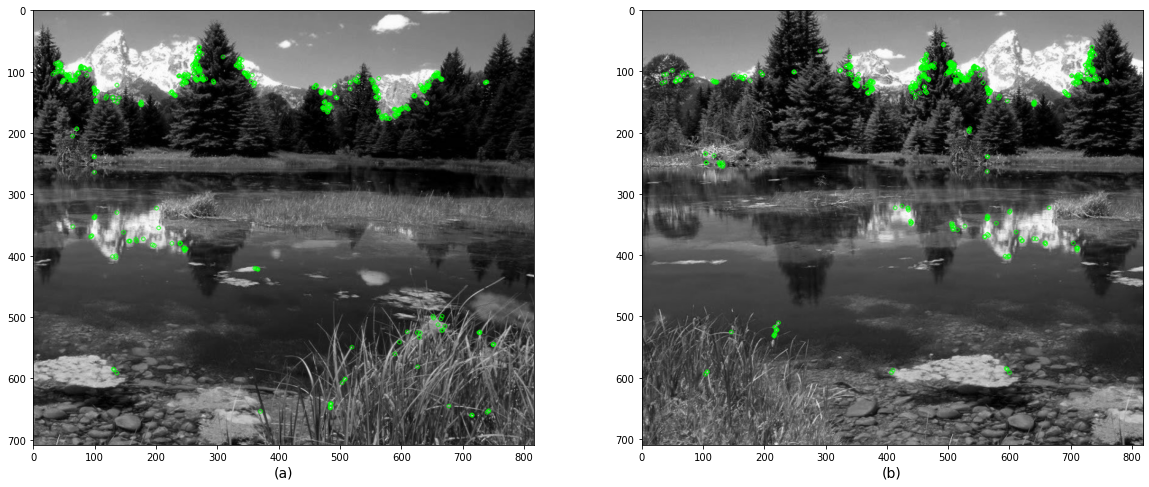

In [76]:
# отобразим ключевые точки и особенности, обнаруженные на обоих изображениях
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [77]:
def createMatcher(method,crossCheck):
    "Создайте и верните объект сопоставления"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [78]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Совпадающие дескрипторы.
    best_matches = bf.match(featuresA,featuresB)
    
    # Отсортируйте объекты в порядке расстояния.
    # Точки с небольшим расстоянием (большее сходство) упорядочиваются первыми в векторе
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [79]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # вычислите исходные совпадения и инициализируйте список фактических совпадений
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # перебирайте необработанные совпадения
    for m,n in rawMatches:
        # убедитесь, что расстояние находится в пределах определенного соотношения друг к другу (например, тест соотношения Лоу).
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 237


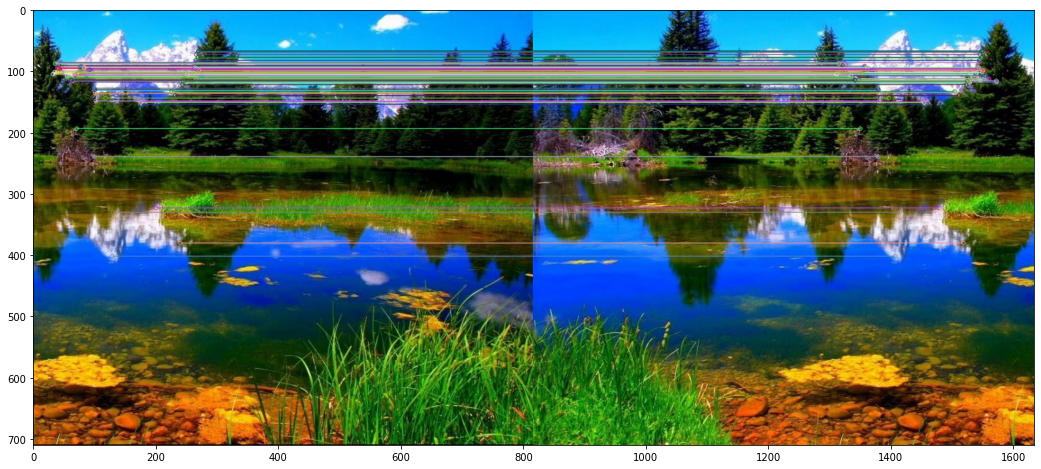

In [80]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

In [81]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # преобразуйте ключевые точки в массивы numpy
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # постройте два набора точек
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # оцените гомографию между наборами точек
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [82]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 9.97985724e-01 -1.14850336e-03  4.63180440e+02]
 [-3.05471300e-04  9.99929954e-01  2.75992786e-02]
 [-1.44458132e-06  1.56349798e-07  1.00000000e+00]]


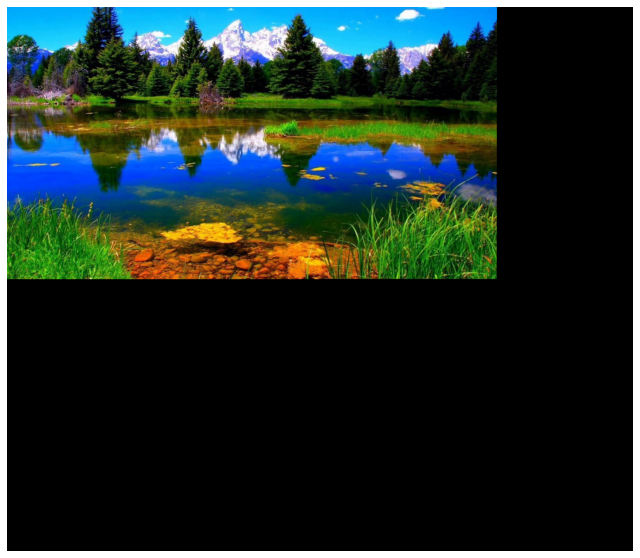

In [83]:
# Применить коррекцию панорамы
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

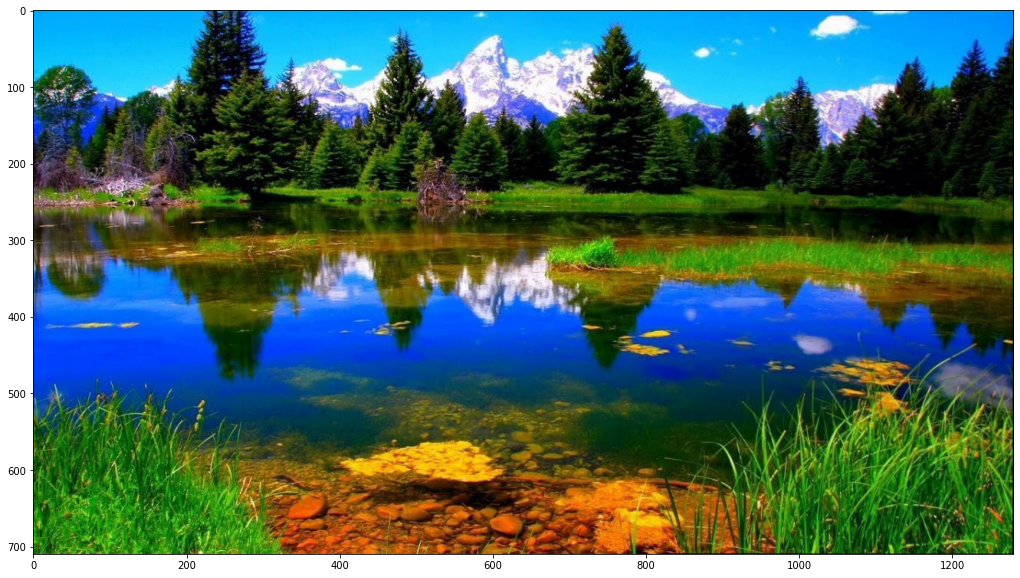

In [84]:
# преобразуйте панорамное изображение в оттенки серого и порогируйте его
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Находит контуры из двоичного изображения
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# получите максимальную площадь контура
c = max(cnts, key=cv2.contourArea)

# получите прямоугольник из области контура
(x, y, w, h) = cv2.boundingRect(c)

# обрезайте изображение до координат
result = result[y:y + h, x:x + w]

# показать обрезанное изображение
plt.figure(figsize=(20,10))
plt.imshow(result)